In [1]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
from torchvision.models import resnet18
from torchvision.models import densenet121

In [2]:
class ResNetModel(nn.Module):
    def __init__(self, num_classes):
        super(ResNetModel, self).__init__()
        self.resnet = resnet18(pretrained=True)
        for param in self.resnet.parameters():
            param.requires_grad = False
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

In [3]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 56 * 56, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.relu3(self.fc1(x))
        x = self.fc2(x)
        return x

In [4]:
class DenseNetModel(nn.Module):
    def __init__(self, num_classes):
        super(DenseNetModel, self).__init__()
        self.densenet = densenet121(pretrained=True)
        num_ftrs = self.densenet.classifier.in_features
        self.densenet.classifier = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.densenet(x)


In [5]:
num_classes = 3

modelo_resnet = ResNetModel(num_classes=3)
modelo_resnet.load_state_dict(torch.load('modelo_resnet.pth'))
modelo_resnet.eval()

modelo_cnn = CNNModel()
modelo_cnn.load_state_dict(torch.load('modelo_propio.pth'))
modelo_cnn.eval()

modelo_densenet = DenseNetModel(num_classes=3)
modelo_densenet.load_state_dict(torch.load('modelo_densenet.pth'))
modelo_densenet.eval()

c:\Users\atrav\anaconda3\envs\pytorch\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\atrav\anaconda3\envs\pytorch\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\atrav\anaconda3\envs\pytorch\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseN

DenseNetModel(
  (densenet): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momen

In [6]:
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [7]:
def predecir_clase(imagen, modelo, clases):
    imagen = data_transform(imagen)
    imagen = imagen.unsqueeze(0)

    output = modelo(imagen)
    _, predicted = torch.max(output, 1)
    nombre_clase = clases[predicted.item()]
    imagen_visualizacion = imagen.squeeze().permute(1, 2, 0).cpu().numpy()
    return nombre_clase, imagen_visualizacion

In [8]:
clases = ['Glioma', 'Meningioma', 'Pituitary tumor']

In [9]:
rutas_de_imagenes = [
    'DatasetTumoresCerebrales/test/Meningioma/17.png',
    'DatasetTumoresCerebrales/test/Glioma/717.png',
    'DatasetTumoresCerebrales/test/Pituitary tumor/926.png'
]

In [10]:
predicciones_individuales = {modelo_resnet: [], modelo_cnn: [], modelo_densenet: []}

for ruta in rutas_de_imagenes:
    for modelo in [modelo_resnet, modelo_cnn, modelo_densenet]:
        imagen = Image.open(ruta).convert('RGB')
        nombre_clase, _ = predecir_clase(imagen, modelo, clases)
        predicciones_individuales[modelo].append(nombre_clase)

In [11]:
predicciones_finales = []

for i in range(len(rutas_de_imagenes)):
    predicciones_temporales = [predicciones_individuales[modelo][i] for modelo in [modelo_resnet, modelo_cnn, modelo_densenet]]
    predicciones, conteos = np.unique(predicciones_temporales, return_counts=True)
    indice_clase_predicha = np.argmax(conteos)
    clase_predicha = predicciones[indice_clase_predicha]
    predicciones_finales.append(clase_predicha)

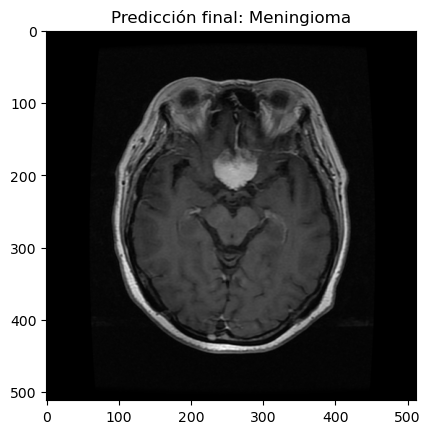

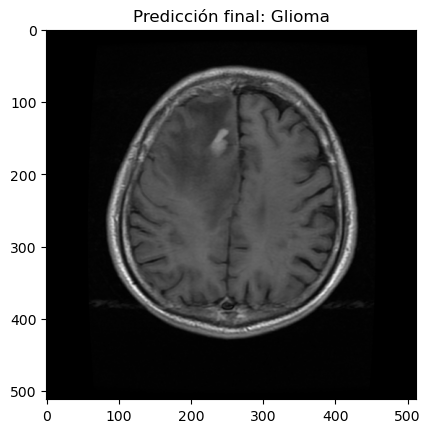

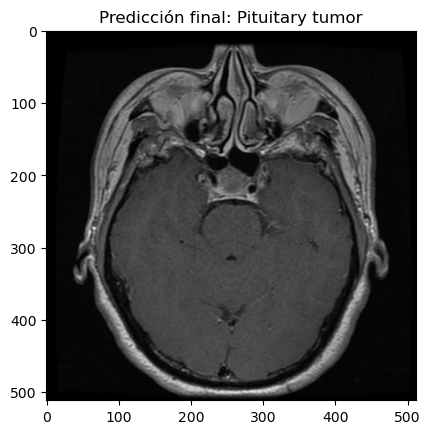

In [12]:
for i, ruta in enumerate(rutas_de_imagenes):
    imagen = Image.open(ruta).convert('RGB')
    plt.imshow(imagen)
    plt.title(f'Predicción final: {predicciones_finales[i]}')
    plt.show()